Note **Need to trim this notebook. Certainly move the pod shop stuff , but maybe more**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader.data as web

def get_factors(factors='CAPM',freq='daily'):   
    
    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
    
     
        df_factor = daily_data[['RF','Mkt-RF']] 
    elif factors=='FF3':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')    
        
    else:
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')   
        fama_french = web.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']    
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp())
    else:
        df_factor.index = pd.to_datetime(df_factor.index)
        


    return df_factor/100

#  Capital Allocation 


---

**🎯 Learning Objectives**



1. **Decompose the capital-allocation problem into two decisions.**  
   Separate “How large should my *risk* portfolio be?” from “How do I spread that risk across assets?” and see why each question has distinct inputs.

2. **Compare the principal vs. delegate perspective.**  
   Understand how required spending, liabilities, or performance evaluation alter the optimal amount of risk for an individual investor versus a professional manager.

3. **Translate expected return and covariance into optimal weights.**  
   Apply the mean–variance framework (or its CAPM special case) to derive recommended positions across stocks, bonds, and factor portfolios.

4. **Allocate between market beta and portable alpha.**  
   Learn the mechanics of combining a hedged long-short (zero-beta) strategy with a market position, and see how the separation theorem guides sizing.

5. **Explore the economics behind “pod shops.”**  
   Understand why multi-manager platforms combine dozens of market-neutral pods, each run at tight risk limits and scaled to a common volatility target.





---



Every investor faces this question: *How much risk should I take, and how should I spread that risk across different assets?*

This chapter will walk you through key concepts and hands-on tools to:
- Decide how much to allocate to risky vs risk-free assets.
- Understand investor behavior (principal vs. delegate).


A fundamental insight of portfolio theory is that these two decisions are separable

1. Investor can first decide on the portfolio that has the best risk-return properties (allocation across assets)
2. Then--given the properties of such portfolio--investors can decide how much to allocate to it vs the risk-free rate

##  Who Decides How Much Risk to Take?

Before diving into the math, let’s think about a fundamental question in portfolio construction:

> 💬 **Who is choosing the portfolio—and what do they care about?**

Every investment decision is ultimately shaped by this.



### 🧍 A. If You’re the **Principal**

You're investing your own money, and **you bear all the risks and rewards**.

Your optimal portfolio depends on:
- Your preferences (especially risk tolerance),
   * How terrible you feel if you have less than you expected
   * How much joy would you enjoy if you had more
- Your investment horizon,
- Your personal financial goals.
    * Minimum retirement income
    * Minimum balance in college fund
    * Minimum budget for health issues
    * Future purchase of a property
- Your background risk
    * Do you have other sources of income? are they risky? 

We often model the principal’s preferences using **expected utility theory**. 

You want more wealth to consume, but are risk averse

$$\max_x U(W(1+rf+r_p))$$


If this utility is mean-variance, this gives rise to the classic trade-off:


$$\text{Maximize:} \quad \mathbb{E}[rf+xr_p] - \frac{\gamma}{2} \text{Var}(xr_p)$$

where:
- $ \mathbb{E}[r_p] $: expected excess return of the risky portfolio  
- $ \gamma $: investor's risk aversion  
- $\text{Var}(r_p)$ : portfolio variance

- The mean-variance criteria will be approximately correct even for other preferences as long returns are close to normal
- We will discuss deviation from normality in our risk management lecture


Your optimal portfolio is given by choosing x to maximize this quadratic function

$$\text{Maximize:} \quad x\mathbb{E}[r_p] - \frac{\gamma}{2} x^2 \text{Var}(r_p)$$


You find any maximum by setting the derivative of the objective with
respect to the choice variable to zero:

$$\mathbb{E}[r_p] -\gamma x \text{Var}(r_p)=0$$


$$x=\frac{\mathbb{E}[r_p]}{\gamma \text{Var}(r_p)}$$

Your optimal portfolio standard deviation is 

$$x\sqrt{\text{Var}(r_p)}=\frac{\mathbb{E}[r_p]}{\gamma \sqrt{\text{Var}(r_p)}}$$


$$x\sigma(r_p)=\frac{1}{\gamma }\frac{\mathbb{E}[r_p]}{ \sigma(r_p)}=\frac{1}{\gamma }\text{Sharpe Ratio}$$


  
```

## How to allocate across assets and trading strategies?



Implicit in our discussion is that you have some desired portfolio with some Sharpe ratio $SR_p$ and you are deciding how to invest in it. 

We can already see that having a large Sharpe ratio is a nice thing to have:
 - Increases the growth of your portfolio per unit of risk
 - For the same growth , you need to take less risk
 - Expected growth means you are less likely to have large losses

But you have to have in mind two things
- There might be stronger  deviations from normality for some trading strategies--for example option based strategies
- for some strategies the moments are particularly poorly estimated in short samples--again option based strategies!
- Useful to always check the "realized tail" of your portfolio in a backtest--more on that soon!

How to build a portfolio that maximizes you SR?

>**If you know** the vectors of expected excess returns across your assets and their variance covariance matrix the answer is easy
> $$W=w E[R^e]\Sigma_{R}^{-1} $$
> This is the MEAN-VARIANCE EFFICIENT PORTFOLIO associated with moments $E[R^e]$,$\Sigma_{R}$
> - $E[R^e]$ is the vector of FORWARD LOOKING expected excess returns across assets
> - $\Sigma_{R}$ is the FORWARD LOOKING variance-covariance matrix
>- w is a scalar that controls the overall size of your portfolio, but does not impact the SR



This same portfolio solves the all following problems

1. $ \max_W E[W'R^e_T]-\gamma/2 Var(W'R^e_T)$
2. $ \max_W E[W'R^e_T]~~~subject~~to~~~Var(W'R^e_T)\leq Vmax $
3. $ \min_W Var(W'R^e_T)~~~subject~~to~~~E[W'R^e_T]\geq Emin $

It should not be surprising! They all want the highest SR, but use it to achieve different goals


Here is the solution for the first one 


$ \max_W E[W'R^e_T]-\gamma/2 Var(W'R^e_T)$

$ \max_W W'E[R^e_T]-\gamma/2 W'Var(R^e_T)W$

You again find any maximum by setting the derivative of the objective with
respect to the choice variable to zero. The only difference is that now you are choosing a vector!


$ E[R^e_T]-\gamma Var(R^e_T)W=0$


$ E[R^e_T]=\gamma Var(R^e_T)W$

$ (\gamma Var(R^e_T))^{-1}E[R^e_T]=(\gamma Var(R^e_T))^{-1}2\gamma Var(R^e_T)W$

$ W=\frac{1}{\gamma}Var(R^e_T)^{-1}E[R^e_T] $


>Insight: 
>
>$\frac{1}{\gamma}$ is simply a scalar that lever-delever your portfolio to hit your desired goal
>
>The maximum Sharpe Ratio portfolio is really given by the term $ W^*=Var(R^e_T)^{-1}E[R^e_T] $
>
>This means that to hit a variance target or a expected return target all you need to do is solve for the leverage that implements it!
>
> For example, suppose I want to hit an expected excess return target of $\mu$, What is my portfolio?
>
> 



Lets apply this to  an international portfolio allocation problem


In [ ]:
url="https://raw.githubusercontent.com/amoreira2/Lectures/main/assets/data/GlobalFinMonthly.csv"
Data = pd.read_csv(url,na_values=-99)
Data['Date']=pd.to_datetime(Data['Date'])
Data=Data.set_index(['Date'])
Rf=Data['RF']
Data=Data.drop(columns=['RF']).subtract(Data['RF'],axis=0)
Data.head()

,MKT,USA30yearGovBond,EmergingMarkets,WorldxUSA,WorldxUSAGovBond
Date,,,,,
1963-02-28,-0.0238,-0.004178,0.095922,-0.005073,NaN
1963-03-31,0.0308,0.001042,0.011849,-0.001929,-0.000387
1963-04-30,0.0451,-0.004343,-0.149555,-0.005836,0.005502
1963-05-31,0.0176,-0.004207,-0.014572,-0.002586,0.002289
1963-06-30,-0.0200,-0.000634,-0.057999,-0.013460,0.000839


In [41]:
# lets assume the sample moments are the true moments of the distribution


muR=Data.mean()
display(muR)
SigmaR=Data.cov()
display(SigmaR)
# this inverts the variance covariance matrix
display(np.linalg.inv(SigmaR))
W= np.linalg.inv(SigmaR) @ muR
display(W)

MKT                 0.005140
USA30yearGovBond    0.002523
EmergingMarkets     0.006923
WorldxUSA           0.004149
WorldxUSAGovBond    0.002054
dtype: float64

,MKT,USA30yearGovBond,EmergingMarkets,WorldxUSA,WorldxUSAGovBond
MKT,0.001948,0.000111,0.001292,0.001264,0.000187
USA30yearGovBond,0.000111,0.001227,-0.000204,-0.000013,0.000264
EmergingMarkets,0.001292,-0.000204,0.003556,0.001661,0.000249
WorldxUSA,0.001264,-0.000013,0.001661,0.002182,0.000422
WorldxUSAGovBond,0.000187,0.000264,0.000249,0.000422,0.000407


array([[ 886.9351877 , -163.1566812 , -133.47716321, -463.61463361,
         260.65110274],
       [-163.1566812 , 1029.7603189 ,   83.97391735,  201.95839425,
        -854.35594033],
       [-133.47716321,   83.97391735,  462.95743432, -276.66588761,
          10.81093193],
       [-463.61463361,  201.95839425, -276.66588761, 1113.82507458,
        -904.79801414],
       [ 260.65110274, -854.35594033,   10.81093193, -904.79801414,
        3826.58967227]])

array([ 1.83533361,  1.42337262,  1.60522251, -1.02642088,  3.36582305])



>- Can you check that the SR of portfolio w*W is invariant to little w?
>- Can you explain  why this is happening?
>- What is the insight? What is the economics of this result? Does it always hold?


Lets look at the relationship between expected returns and volatility as we vary the size of the portfolio w, while fixing the allocation W

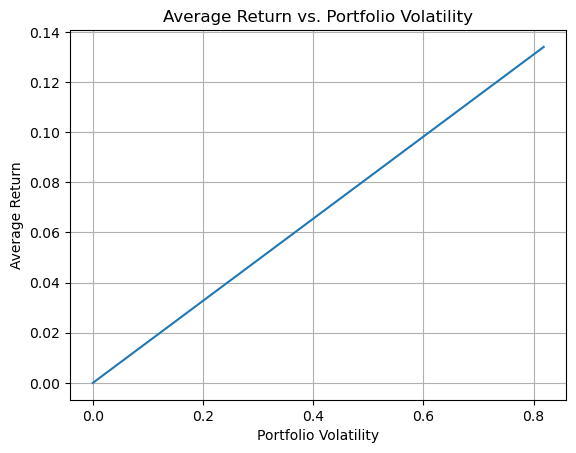

In [42]:
# Define the range of w values
w_values = np.linspace(0, 5, 100)

# Calculate the portfolio returns and volatilities for each w
portfolio_returns = []
portfolio_volatilities = []

for w in w_values:
    weights = w * np.linalg.inv(SigmaR) @ muR
    portfolio_return = weights @ muR
    portfolio_volatility = np.sqrt(weights @ SigmaR @ weights)
    
    portfolio_returns.append(portfolio_return)
    portfolio_volatilities.append(portfolio_volatility)

# Plot the results
plt.plot(portfolio_volatilities, portfolio_returns)
plt.xlabel('Portfolio Volatility')
plt.ylabel('Average Return')
plt.title('Average Return vs. Portfolio Volatility')
plt.grid(True)
plt.show()



What does it mean that the relationship between Expected return and volatility is linear?

Is that what you expect? Is that true in general as you change portfolio weights?

## Alpha bets 






It is useful to decompose your allocation in terms of "factor bets" and "alpha bets"

Most fund managers have tight limits on factor exposures anyways, so factor exposure is more of a consequence of your alpha bets that you need to control rather then a form of investing for most fund managers. If you are a large capital allocator, like a Pension fund or a university endowment then factor bets are also very important, since on average most portfolios risk must be dominated by common factors


Let's say that you identified N trading strategies

- You believe their alphas are A (N by 1)
- You estimate their factor Betas B (N by 1) (single factor model for now)
- And their idio variance $\Sigma_{\epsilon}$, which is diagonal. These are idio bets after you remove the factor exposure
- You have a mandate to have zero factor exposure.

What is your optimal portfolio ( we are focusing now on the composition, lets put the level of risk aside) ?
- What is your allocation on each trading strategy?
- Assuming you can trade the factor, how much of it you buy/sell directly?







  


The solution is $w*W$ and $w*W_f$ for any scalar w, where

$W=A\Sigma_{\epsilon}^{-1}$ 

$W_f=-W'\Beta$

and you pick w to control the overall volatility of your portfolio and where
$$A\Sigma_{\epsilon}^{-1}=\left[\alpha_1,\alpha_2,...,\alpha_N\right]\left[\begin{array}{ccc}\sigma^2_{\epsilon,1} & 0 & 0\\0 & \sigma^2_{\epsilon,i} & 0\\0&0&\sigma^2_{\epsilon,N}\end{array}\right]^{-1}=\left[\begin{array}{c}\frac{\alpha_1}{\sigma^2_{\epsilon,1} }\\\frac{\alpha_2}{\sigma^2_{\epsilon,2} }\\...\\\frac{\alpha_N}{\sigma^2_{\epsilon,N} }\end{array}\right]$$


The fact that all the trading strategies are stripped out of the co-movement leads to a really clean formula

You can rewrite in terms of volatility allocations in each strategy

$$W_i\sigma_{\epsilon,i}=\frac{\alpha_i}{\sigma_{\epsilon,i}}$$

We refer to $\frac{\alpha_i}{\sigma_{\epsilon,i}}$ as the strategy **Appraisal Ratio**. Sometimes people call this the "information ratio". It is the "sharpe ratio" of the trading strategy striped out of factor exposure

- recall that $\sigma_{\epsilon,i}$ is the volatility of the strategy that is long the asset and short the factor in the optimal hedging 

$$r^e_i-h^if=\alpha_i+\beta_i*f+\epsilon_i+hf$$

so if you set $h=-\beta_i$

$$r^e_i-h^if=\alpha_i+\epsilon_i$$

and follows that $E[r^e_i-h^if]=\alpha_i$ and $Var(r^e_i-h^if)=\sigma_{\epsilon,i}^2$

>How do we do this for this international allocation problem using the US market as the common factor?

In [ ]:
ADJUST !!!

In [ ]:
import statsmodels.api as sm

# Define the factors and the market factor
factors = ['SMB', 'HML', 'RMW', 'CMA', 'MOM']
market_factor = 'Mkt-RF'

# Initialize lists to store the results
Alpha = []
Beta = []
residuals = []
Alpha_se = []
Hedged_factors=[]
# Run univariate regressions with the market as the factor
df_sample=df_ff6['1970':'2000']
for factor in factors:
    X = sm.add_constant(df_ff6[market_factor])
    y = df_ff6[factor]
    model = sm.OLS(y, X).fit()
    Alpha.append(model.params['const'])
    Beta.append(model.params[market_factor])
    residuals.append(model.resid)
    Hedged_factors.append(model.params['const']+model.resid)
    # What is an alternative approach to construct the hedged factor?


# Convert Alpha and Beta to numpy arrays
Alpha = np.array(Alpha)
Beta = np.array(Beta)

# Calculate the variance-covariance matrix of the residuals
Hedged_factors = pd.DataFrame(np.vstack(Hedged_factors).T)
Hedged_factors.columns = factors
residuals_matrix = np.vstack(residuals).T
Sigma_e =np.diag(np.cov(residuals_matrix.T))

# Display the results
print("Alpha:", Alpha*12)
print("Beta:", Beta)
print("Sigma_e:", Sigma_e*12)

In [ ]:
# optimal weights for the hedged factors
W=Hedged_factors.mean()@ np.linalg.inv(Hedged_factors.cov())
# lets leverage it to have a yearly vol of 16%

W = W / np.sqrt(W @ Hedged_factors.cov() @ W.T) * 0.16


W

##  How to Combine the  Hedged portfolio (alpha) and the Market (beta)



- If you see your investment in the factor as simply a financial issue
  - you care exclusively about the returns of the portfolio
  - Do not care how the factor (i.e. the market) might co-move with your non-financial wealth--say when the market tanks, recession is more likely and you are more likely to lose your job
  
- Then it is basically the same as with the alphas...
- But still useful to separate as you probably have different confidence on the market risk-premium than on the alphas
- Recall our formula for the mean-variance efficient weights


$$W^*= Var(R^e)^{-1}E[R^e]$$

- Now this becomes really simple because the covariance of the new Hedged-MVE strategy is zero with the market

$$Var(R^e)=\left[\begin{array}{cc} \sigma^2(R_{MKT}^e) & 0\\0 & \sigma^2(R_{Hedged,i})\end{array}\right]$$

- So the optimal weights are just

$$W^* = \left[\begin{array}{c} \frac{E[R^e_{MKT}]}{\sigma^2(R_{MKT}^e)} \\ \frac{\alpha}{\sigma^2(R_{Hedged,i})}\end{array}\right]$$


- You invest in each strategy according to the strength of the risk-return trade-off in the strategy

- Note that anything that invest proportionally in those two assets will still be tangency, i.e. if $W^*$ is tangency $0.3*W^*$ is tangency as well!

- But how much you invest overall will depend on how much risk you want to take

- Of course similar uncertainty issues might push you to deviate from this rule!


> What is the optimal combination between your alpha combo portfolio and the market?

> By how much can you increase your portfolio Sharpe ratio if you combine optimally combine two uncorrelated portfolios? 

- for any two strategies A and B that have **zero correlation** with each other, you can find the maximum achievable Sharpe Ratio with the simple formula 

$$SR_{final}=\sqrt{SR_{A}^2+SR_{B}^2}$$

- The Hedged and the market are orthogonal by construction--> we took out any beta exposure the asset might have!


$$SR_{final}=\sqrt{SR_{MKT}^2+SR_{Hedged}^2}$$



>If you care about the Sharpe ratio of your final portfolio, you do not care about the Sharpe ratio of a particular strategy-
> You instead care about the Sharpe ratio of the strategy after you hedged out your current portfolio
> You care about the appraisal ratio of the strategy relative to your portfolio

---
**📝 Key Takeaways**


- **Risk size and asset mix are separate levers.**  First decide how much volatility (or drawdown) you can stomach; only then choose the combination of assets or factors that delivers the best reward for that risk.  
- **Know your maximum loss**: figure out how much vol you should have in your portfolio
- **Portfolio composition** is all about the Sharpe Ratio
- **Portable alpha plus market beta is a practical implementation of the separation theorem.**  A zero-beta long–short can be layered on top of any core market exposure to raise expected return without changing systematic risk.  
- **Characteristic factors need the same discipline as traditional assets.**  Evaluate their alpha, beta, and covariance before adding them—high standalone Sharpe means little if the factor simply doubles your market risk. 
- **Diversification is your friend**, estimation uncertainty your mortal enemy

----